# Next-word Generator for the Sherlock Holmes dataset


## Imports and Initial Configuration

In [2]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import plotly.express as px  # For interactive plotting
import plotly.graph_objects as go
import re
import os
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# Set up Plotly for better visualization
import plotly.io as pio
pio.renderers.default = 'notebook_connected'

# Display PyTorch version and set device
print(f"PyTorch Version: {torch.__version__}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define dataset directory
dataset_dir = os.path.join(os.getcwd(), 'datasets')


PyTorch Version: 2.2.1+cu121
Using device: cpu


### Tokenizing C Code and Removing Comments

This cell defines two functions to process and tokenize C code: `remove_multiline_comments` and `tokenize_c_code`. 

- **`remove_multiline_comments`**: 
    - This function removes all multiline comments (i.e., `/* ... */`) from the input code using regular expressions.
    - It uses the `re.DOTALL` flag to match comments across multiple lines.

- **`tokenize_c_code`**:
    - This function takes a filename containing C code, reads and processes the code, and outputs a list of tokens.
    - **Preprocessing Steps**:
        - Reads the file and removes any multiline comments with `remove_multiline_comments`.
        - Removes single-line comments using a regular expression.
    - **Token Specification**:
        - The function defines a list `token_specification` that includes patterns for various C components (e.g., keywords, operators, data types).
        - Each token pattern is defined as a tuple with the token type and its regex pattern.
    - **Token Extraction**:
        - All patterns are compiled into a single regex, which is matched iteratively through the code to extract tokens.
        - Special tokens (`\s` for whitespace and `\n` for newlines) are explicitly added to preserve structure.
    - **Output**:
        - Returns a list of token values, where newlines are represented as `'\n'` tokens, and spaces as `'\s'`.


In [3]:
import re

def remove_multiline_comments(code):
    """
    Removes multiline comments from C code.
    """
    multiline_comment_pattern = re.compile(r'/\*.*?\*/', re.DOTALL)
    code = re.sub(multiline_comment_pattern, '', code)
    return code

def tokenize_c_code(filename):
    """
    Tokenizes C code into a list of tokens, returning only the token values as strings.
    Newlines are represented explicitly as '\n' tokens.
    """
    # Remove multiline comments
    filepath = os.path.join(dataset_dir, filename)
    with open(filepath, encoding='utf-8') as file:
        code = file.read()
        
    code = remove_multiline_comments(code)
    
    # Remove single-line comments
    code = re.sub(r'//.*', '', code)
    
    # Token patterns for various C components
    token_specification = [
        ('INCLUDE', r'#include'),                             # Capture #include separately
        ('HEADER',  r'<[^>]+>'),                              # Capture the header file within angle brackets
        ('PREPROCESSOR', r'#\s*(define|ifdef|ifndef|endif)'), # Other preprocessor directives
        ('MACRO', r'#\s*define\s+[^\n]+'),                    # Macro definitions
        ('KEYWORD', r'\b(auto|break|case|char|const|continue|default|do|double|else|enum|extern|'
                    r'float|for|goto|if|inline|int|long|register|restrict|return|short|signed|sizeof|'
                    r'static|struct|switch|typedef|union|unsigned|void|volatile|while)\b'),  # Keywords
        ('TYPE', r'\b(int|char|float|double|void|short|long)\b'),  # Data types
        ('IDENTIFIER', r'\b[A-Za-z_][A-Za-z0-9_]*\b'),            # Identifiers (variable and function names)
        ('NUMBER', r'\b\d+(\.\d+)?\b'),                           # Numeric literals (integer or floating-point)
        ('STRING_LITERAL', r'"(?:\\.|[^"\\])*"'),                 # String literals with escaped characters
        ('CHAR_LITERAL', r"'(?:\\.|[^'\\])'"),                    # Character literals with escaped characters
        ('OPERATOR', r'==|!=|<=|>=|->|&&|\|\||\+\+|--|'
                     r'[+\-*/%=&|<>!~^]'),                        # Multi-character and single-character operators
        ('DELIMITER', r'[;:,.\[\]\(\)\{\}]'),                     # Delimiters
        ('NEWLINE', r'\n'),                                       # Newlines as '\n' tokens
        ('WHITESPACE', r'[ \t]+'),                                # Skip spaces and tabs
        ('MISMATCH', r'.'),                                       # Any other character (error handling)
    ]
    
    # Compile all patterns into a single regex
    tok_regex = '|'.join('(?P<%s>%s)' % pair for pair in token_specification)
    get_token = re.compile(tok_regex).match

    tokens = []
    pos = 0
    mo = get_token(code)
    
    while mo is not None:
        kind = mo.lastgroup
        value = mo.group()

        # Add only token values to the tokens list, treating newlines as '\n'
        if kind == 'WHITESPACE':
            tokens.append('\s')  # Explicitly add newline character
        elif kind == 'NEWLINE':
            tokens.append('\n')  # Explicitly add newline character
        elif kind == 'MISMATCH':
            # Handle unexpected characters if needed (log or raise an error)
            pass
        else:
            tokens.append(value)  # Append only the token value
        
        pos = mo.end()
        mo = get_token(code, pos)
    
    return tokens


### Generating Unique Token Mappings

The `unique_tokens` function generates unique token mappings from a list of tokens produced by the tokenizer.

- **Input**:
    - A list of tokens that may contain duplicates.
  
- **Output**:
    - **Vocabulary (`vocab`)**: A sorted list of unique tokens.
    - **Mappings**:
        - `stoi` (String-to-Index): A dictionary that maps each token in `vocab` to a unique index.
        - `itos` (Index-to-String): A dictionary that maps each index back to its corresponding token.
  
- **Special Tokens**:
    - Adds a special `<UNK>` token at the start of `stoi` to represent unknown tokens in future operations.


In [4]:
def unique_tokens(tokens: list):
    """
    Generates unique token mappings from a list of tokens.
    Includes <UNK> token for unknown tokens.
    """
    # Convert to set to get unique tokens, then back to sorted list
    vocab = sorted(set(tokens))
    
    # Initialize stoi with the <UNK> special token
    special_tokens = ['<UNK>']
    stoi = {token: i + 1 for i, token in enumerate(special_tokens)}
    
    # Add remaining unique vocabulary tokens, starting from the next available index
    next_index = len(stoi) + 1
    for token in vocab:
        if token not in stoi:
            stoi[token] = next_index
            next_index += 1
    
    # Create the itos mapping from updated stoi
    itos = {i: s for s, i in stoi.items()}
    
    return vocab, stoi, itos


### Preparing Data for Model Training

The `prepare_data` function creates input-output pairs from a list of tokens, which are then used to train a language model.

- **Input**:
    - `tokens`: A list of tokens.
    - `block_size`: The context window size, specifying how many tokens each input sequence will contain.
    - `stoi`: The string-to-index mapping for tokens.

- **Output**:
    - Tensors `X` and `Y` for training:
        - `X` contains sequences of `block_size` tokens as context.
        - `Y` contains the next token following each context as the target.
  
- **Process**:
    - Generates `X` and `Y` by iterating over the `tokens` list and creating context-target pairs.
    - Converts each token in the context and target to its corresponding index using `stoi`, with unknown tokens mapped to `<UNK>`.

- **Data Conversion**:
    - `X` and `Y` are converted into PyTorch tensors for use in model training.


In [5]:
def prepare_data(tokens: list, block_size: int, stoi):
    """
    Prepares input-output pairs for training from a list of tokens.
    Each input consists of `block_size` tokens, and the target is the next token.
    Unknown tokens are mapped to the <UNK> index.
    """
    X, Y = [], []
    
    # Define the <UNK> token
    unk_token = '<UNK>'
    unk_idx = stoi.get(unk_token, len(stoi) + 1)  # Get or add <UNK> index if not in stoi

    # Generate input-output pairs
    for i in range(block_size, len(tokens)):
        context = tokens[i-block_size:i]
        target = tokens[i]
        
        # Convert context and target to indices, mapping unknown tokens to <UNK>
        context_ix = [stoi.get(token, unk_idx) for token in context]
        target_ix = stoi.get(target, unk_idx)
        
        X.append(context_ix)
        Y.append(target_ix)
    
    # Convert lists to tensors
    X = torch.tensor(X, dtype=torch.long).to(device)
    Y = torch.tensor(Y, dtype=torch.long).to(device)
    
    return X, Y


## Data Cleaning and Preparation
We clean the text, build the vocabulary, and prepare the data for training.

In [6]:

# Clean the text from the dataset
text = tokenize_c_code('/teamspace/studios/this_studio/es335-24-fall-assignment-3/datasets/linux.txt')

# Extract unique words and create mappings
vocab, stoi, itos = unique_tokens(text)

# Add the <UNK> token to itos
itos[stoi['<UNK>']] = '<UNK>'

# Prepare input-output pairs with a context window of 5
block_size = 5
X, Y = prepare_data(text, block_size, stoi)

# Display the shapes of the tensors
print(f"Input shape: {X.shape}, dtype: {X.dtype}")
print(f"Target shape: {Y.shape}, dtype: {Y.dtype}")

Input shape: torch.Size([1114127, 5]), dtype: torch.int64
Target shape: torch.Size([1114127]), dtype: torch.int64


In [7]:
# %%
# Number of samples to display
num_samples = 5

print(f"Displaying {num_samples} sample input-output pairs:\n")

# Iterate over the first num_samples and print context and target
for i in range(num_samples):
    # Get context indices and target index
    context_indices = X[i].tolist()
    target_index = Y[i].item()
    
    # Convert indices back to words, using <UNK> for unknown indices
    context_words = [itos.get(idx, '<UNK>') for idx in context_indices]
    target_word = itos.get(target_index, '<UNK>')
    
    # Print the context and target
    print(f"--- Sample {i+1} ---")
    print(f"Context: {' '.join(context_words)}")
    print(f"Target: {target_word}\n")


Displaying 5 sample input-output pairs:

--- Sample 1 ---
Context: 
 
 #include \s <linux/irq.h>
Target: 


--- Sample 2 ---
Context: 
 #include \s <linux/irq.h> 

Target: #include

--- Sample 3 ---
Context: #include \s <linux/irq.h> 
 #include
Target: \s

--- Sample 4 ---
Context: \s <linux/irq.h> 
 #include \s
Target: <linux/module.h>

--- Sample 5 ---
Context: <linux/irq.h> 
 #include \s <linux/module.h>
Target: 




## Embedding Initialization and Visualization

We initialize the embedding layer and visualize the embeddings using t-SNE with Plotly.

In [8]:
# %%
# Define hyperparameters
embedding_dim = 256  # Increased embedding size

# Initialize the embedding layer
embedding = nn.Embedding(len(stoi) + 1, embedding_dim).to(device)  # +1 for padding if needed
print(f"Embedding Weights Shape: {embedding.weight.shape}")

# Convert embeddings to NumPy for visualization
embeddings = embedding.weight.detach().cpu().numpy()

# Perform t-SNE to reduce dimensions to 2D
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Create a DataFrame for Plotly
words = list(stoi.keys())
df = pd.DataFrame({
    'word': words,
    'x': embeddings_2d[:len(words), 0],
    'y': embeddings_2d[:len(words), 1]
})

# Plot using Plotly Express
fig = px.scatter(
    df, 
    x='x', 
    y='y', 
    hover_name='word',  # Display word only on hover
    title='t-SNE Visualization of Word Embeddings',
    width=800,
    height=800
)

# Customize the plot to hide text labels and show only dots
fig.update_traces(
    marker=dict(size=5, color='blue'),  # Customize dot color and size
    hovertemplate='<b>%{hovertext}</b><extra></extra>'  # Show only the word on hover
)
fig.update_layout(
    title=dict(x=0.5),
    xaxis_title="t-SNE Dimension 1",
    yaxis_title="t-SNE Dimension 2",
    template='plotly_white'
)

fig.show()

Embedding Weights Shape: torch.Size([28885, 256])


KeyboardInterrupt: 

### Model Definition and Mini-Batch Gradient Descent Training Setup

This cell defines the model architecture, initializes hyperparameters, and prepares the DataLoader for mini-batch gradient descent.

1. **Define Hyperparameters**:
    - `hidden_dim`: Sets the size of the hidden layer to 512.
    - `epochs`: Specifies 50 training epochs.
    - `learning_rate`: Sets the learning rate for the optimizer to 0.001.
    - `batch_size`: Defines the batch size as 2048 for mini-batch gradient descent.

2. **Model Architecture** - `NextWord` Class:
    - A feedforward neural network is defined for next-word prediction with four hidden layers, each followed by a Leaky ReLU activation function.
    - **Layers**:
        - `embedding`: An embedding layer for mapping tokens to dense vectors of a given `embedding_dim`.
        - `lin1` to `lin4`: Four fully connected layers with `LeakyReLU` activations, allowing for gradient flow even with negative inputs.
        - `lin_out`: The output layer, which maps to the vocabulary size, giving the probability of each possible next word.
    - **Forward Pass** (`forward` method):
        - The input tokens are passed through the embedding layer, then flattened.
        - The embedding is processed through each linear layer (`lin1` to `lin4`), followed by Leaky ReLU activations.
        - The output layer (`lin_out`) produces the final logits.

3. **Model Initialization**:
    - The model is instantiated using the specified `block_size`, vocabulary size (`len(stoi) + 1`), `embedding_dim`, and `hidden_dim`.

4. **DataLoader Preparation**:
    - `create_data_loader` is a helper function that takes input (`X`) and target (`Y`) tensors and returns a DataLoader for batch processing.
    - The function uses `TensorDataset` to combine `X` and `Y`, and `DataLoader` to batch the dataset with a size of 2048, shuffling data for each epoch.

5. **Define Loss Function and Optimizer**:
    - **Loss Function**: Uses `CrossEntropyLoss`, which is suitable for multi-class classification, as it calculates the difference between predicted and true next-word tokens.
    - **Optimizer**: Uses `AdamW` (Adam with weight decay) to minimize the loss with the specified learning rate.


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Define hyperparameters
hidden_dim = 512
epochs = 50
learning_rate = 0.001
batch_size = 2048  # Define the batch size for mini-batch gradient descent

# Define the model
class NextWord(nn.Module):
    """
    A feedforward neural network with multiple hidden layers for next-word prediction.
    Utilizes Leaky ReLU activation functions to improve gradient flow.
    """
    def __init__(self, block_size, vocab_size, embedding_dim, hidden_dim):
        super(NextWord, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lin1 = nn.Linear(embedding_dim * block_size, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, hidden_dim)
        self.lin3 = nn.Linear(hidden_dim, hidden_dim)
        self.lin4 = nn.Linear(hidden_dim, hidden_dim)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.1)
        self.lin_out = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        embeds = self.embedding(x)
        embeds = embeds.view(x.shape[0], -1)
        
        out = self.leaky_relu(self.lin1(embeds))
        out = self.leaky_relu(self.lin2(out))
        out = self.leaky_relu(self.lin3(out))
        out = self.leaky_relu(self.lin4(out))
        
        return self.lin_out(out)

# Initialize the model
model = NextWord(block_size, len(stoi) + 1, embedding_dim, hidden_dim).to(device)

# Prepare DataLoader for mini-batch gradient descent
def create_data_loader(X, Y, batch_size):
    dataset = TensorDataset(X, Y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Assuming X, Y are tensors prepared by the prepare_data function
data_loader = create_data_loader(X, Y, batch_size)

# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

## Training Loop

Epoch 1/50, Loss: 2.6596


Epoch 5/50, Loss: 1.5423
Epoch 10/50, Loss: 1.1717
Epoch 15/50, Loss: 0.9998
Epoch 20/50, Loss: 0.9281
Epoch 25/50, Loss: 0.8884
Epoch 30/50, Loss: 0.8709
Epoch 35/50, Loss: 0.8501
Epoch 40/50, Loss: 0.8367
Epoch 45/50, Loss: 0.8363
Epoch 50/50, Loss: 0.8266


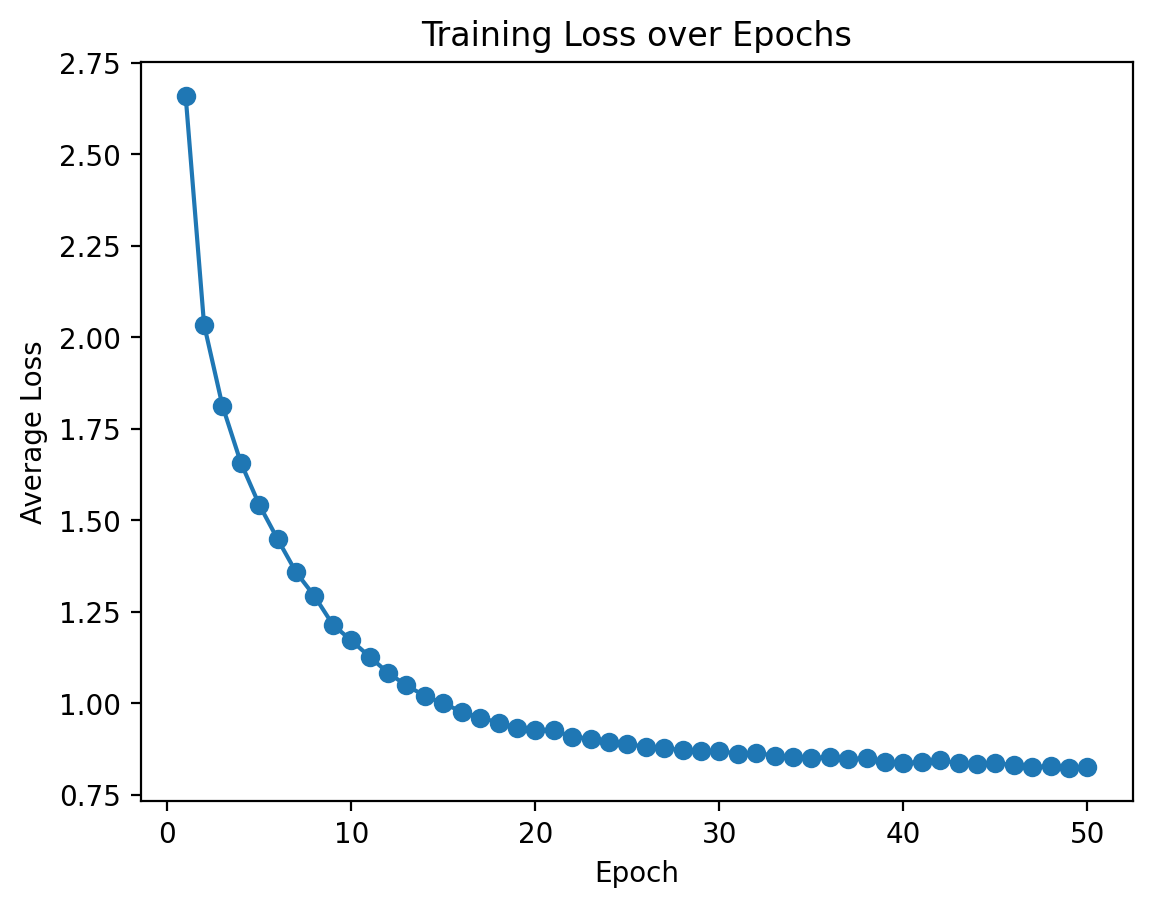

In [ ]:
import matplotlib.pyplot as plt

# List to store the average loss for each epoch
loss_history = []

# Training loop with mini-batch gradient descent
for epoch in range(1, epochs + 1):
    model.train()  # Set model to training mode
    total_loss = 0  # Track total loss for the epoch
    
    for batch_X, batch_Y in data_loader:
        # Move batches to device
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
        
        # Forward pass
        outputs = model(batch_X)
        loss = loss_fn(outputs, batch_Y)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        total_loss += loss.item()
    
    # Average loss per epoch
    avg_loss = total_loss / len(data_loader)
    loss_history.append(avg_loss)  # Store the average loss

    # Print progress every 5 epochs
    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch}/{epochs}, Loss: {avg_loss:.4f}")

# Plot the loss history
plt.plot(range(1, epochs + 1), loss_history, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Training Loss over Epochs")
plt.show()


## Saving the model

In [ ]:
model_save_path = 'models/c_nextword_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to models/c_nextword_model.pth


## Loading the saved model (if not training from scratch)

In [ ]:
model_save_path = 'models/c_nextword_model.pth'
model = NextWord(block_size, vocab_size, embedding_dim, hidden_dim).to(device)
model.load_state_dict(torch.load(model_save_path))
model.eval()  # Set to evaluation mode if not training further

## Generating Text Sequences
We generate sample text sequences using the trained model.

In [ ]:
def generate_code(model, itos, stoi, context_words, block_size, max_len=20):
    """
    Generates a sequence of C code tokens based on the provided context.
    Treats punctuation, newline, and space tokens appropriately for code formatting.
    Ensures that punctuation and special tokens are appended correctly without additional spaces.
    """
    model.eval()  # Set model to evaluation mode
    unk_idx = stoi.get('<UNK>', 0)  # Index for unknown words
    
    # Convert context words to indices, mapping unknown words to <UNK>
    context = [stoi.get(word, unk_idx) for word in context_words]
    
    # Pad context if it's shorter than block_size
    if len(context) < block_size:
        context = [unk_idx] * (block_size - len(context)) + context
    
    sequence = context_words.copy()
    generated_code = ''  # Initialize an empty string to build generated code
    
    with torch.no_grad():
        for _ in range(max_len):
            # Prepare input tensor
            x = torch.tensor(context[-block_size:]).unsqueeze(0).to(device)  # Shape: [1, block_size]
            
            # Get model predictions
            y_pred = model(x)  # [1, vocab_size]
            
            # Apply softmax to get probabilities
            probs = F.softmax(y_pred, dim=1)
            
            # Sample from the distribution
            ix = torch.multinomial(probs, num_samples=1).item()
            word = itos.get(ix, '<UNK>')
            
            # Convert \n and \s escape sequences to actual characters
            if word == '\n':
                generated_code += '\n'
            elif word == '\s':
                generated_code += ' '
            else:
                generated_code += word  # Append token without spaces
            
            # Update the context with the generated word's index
            context.append(ix)
    
    return generated_code

# Define some initial contexts for generating C code sequences
c_code_contexts = [
    "int main() {",
    "if (a > 0) {",
    "while (i < 10) {",
    "printf(",
    "for (int i = 0;",
    "return 0;",
    "int sum =",
    "char buffer[256];",
    "void process_data(int data) {",
    "float value ="
]

# Iterate over each context and generate sequences
for idx, context in enumerate(c_code_contexts, 1):
    # Generate a sequence of 50 tokens based on the context
    generated_sequence = generate_code(
        model=model,
        itos=itos,
        stoi=stoi,
        context_words=context.split(),
        block_size=block_size,
        max_len=100
    )
    
    # Print the results
    print(f"--- Sequence {idx} ---")
    print(f"Context: {context}")
    print(f"Generated code sequence:\n{context} {generated_sequence}\n")


--- Sequence 1 ---
Context: int main() {
Generated code sequence:
int main() { )
 return sa_sd_storage;
 d->swapin_delay_total + tsk->utime;

 return -EINVAL;

 free_cpumask_var(cpu_online_mask);
 cpumask_clear_cpu(cpu, tick_broadcast_oneshot_mask)) {
 dest->counts[i].values, ctr->values, size * sizeof(u64); 
 fsnotify_put_mark(old_entry); 
 } 
 }
}

void get_usage_chars(struct lock_class

--- Sequence 2 ---
Context: if (a > 0) {
Generated code sequence:
if (a > 0) {  index, ndw = ACCESS_ONCE(jiffies);
 if (!desc->dir)
 return;
 }
 }

 return 0;

 if (WARN_ON_ONCE(lock_is_write_held))
 entry->rule.flags = CFTYPE_ONLY_ON_ROOT,
 .flags = NULL;
 free_percpu(pd->squeue);
 kfree(register_tracer(&uoss) != root_task_group)
 return ERR_PTR

--- Sequence 3 ---
Context: while (i < 10) {
Generated code sequence:
while (i < 10) {  cgrp2) {
 if (current->flags &= ~CSS_ONLINE;
 RCU_INIT_POINTER(event->pmu->module);
 }
 return 0;
}
#endif 
 .print_header = blk_tracer_print_header,
 .print_line = prin

## t-SNE Visualization of Trained Embeddings
Finally, we visualize the trained word embeddings using t-SNE with Plotly.

In [ ]:
# %%
# Extract trained embeddings
trained_embeddings = model.embedding.weight.detach().cpu().numpy()

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
trained_embeddings_2d = tsne.fit_transform(trained_embeddings)

# Create DataFrame for Plotly
trained_df = pd.DataFrame({
    'word': list(stoi.keys()),
    'x': trained_embeddings_2d[:len(stoi), 0],
    'y': trained_embeddings_2d[:len(stoi), 1]
})

# Plot using Plotly Express without displaying word labels
fig = px.scatter(
    trained_df, 
    x='x', 
    y='y', 
    # Remove the 'text' parameter to hide word labels
    title='t-SNE Visualization of Trained Word Embeddings',
    hover_name='word',  # Set the word to appear on hover
    hover_data={'x': False, 'y': False},  # Exclude x and y from hover
    width=800,
    height=800
)

# Customize the plot by removing text-related trace settings
fig.update_traces(
    marker=dict(size=5)
    # Removed textposition and textfont since text labels are not displayed
)
fig.update_layout(
    title=dict(x=0.5),
    xaxis_title="t-SNE Dimension 1",
    yaxis_title="t-SNE Dimension 2",
    template='plotly_white'
)

fig.show()


## t-SNE plot in 3D

In [ ]:
# %%
from sklearn.manifold import TSNE
import pandas as pd
import plotly.express as px
import torch
import re

# Ensure that 'stoi' and 'itos' are defined
if 'stoi' not in globals() or 'itos' not in globals():
    raise NameError("'stoi' and/or 'itos' are not defined. Please run the data preparation cells first.")

# Verify that the model has an embedding layer
if not hasattr(model, 'embedding'):
    raise AttributeError("The model does not have an 'embedding' attribute.")

# Extract trained embeddings from the model
trained_embeddings = model.embedding.weight.detach().cpu().numpy()
print(f"Shape of trained_embeddings: {trained_embeddings.shape}")
print(f"Number of words in 'stoi': {len(stoi)}")

# Assuming index 0 is reserved for padding, exclude it
# Ensure that trained_embeddings has len(stoi) + 1 embeddings
expected_embeddings = len(stoi) + 1  # +1 for padding
actual_embeddings = trained_embeddings.shape[0]

if actual_embeddings != expected_embeddings:
    raise ValueError(f"Mismatch between embeddings ({actual_embeddings}) and vocabulary size + padding ({expected_embeddings}).")

# Perform t-SNE in 3D
tsne = TSNE(n_components=3, random_state=42)
trained_embeddings_3d = tsne.fit_transform(trained_embeddings)

# Create a DataFrame for Plotly
# Exclude the first embedding (index 0) which is for padding
words = list(stoi.keys())
if actual_embeddings - 1 != len(words):
    raise ValueError(f"After excluding padding, number of words ({len(words)}) does not match embeddings ({actual_embeddings - 1}).")

df = pd.DataFrame({
    'word': words,
    'x': trained_embeddings_3d[1:, 0],  # Skip index 0
    'y': trained_embeddings_3d[1:, 1],
    'z': trained_embeddings_3d[1:, 2]
})

# Plot in 3D using Plotly Express
fig = px.scatter_3d(
    df, 
    x='x', 
    y='y', 
    z='z', 
    hover_name='word',  # Show word on hover
    hover_data={'x': False, 'y': False, 'z': False},  # Hide coordinates on hover
    title='3D t-SNE Visualization of Trained Word Embeddings',
    width=800,
    height=800
)

# Customize the plot
fig.update_traces(
    marker=dict(size=5, color='blue', opacity=0.7)
)
fig.update_layout(
    title=dict(x=0.5, y=0.95, xanchor='center', yanchor='top'),
    scene=dict(
        xaxis_title="t-SNE Dimension 1",
        yaxis_title="t-SNE Dimension 2",
        zaxis_title="t-SNE Dimension 3"
    ),
    template='plotly_white'
)

fig.show()


Shape of trained_embeddings: (28885, 256)
Number of words in 'stoi': 28884
